In [1]:
!pip install "tensorflow>=2.15.0"
!pip install --upgrade tensorflow-hub
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/drive/MyDrive
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

Mounted at /content/gdrive
[Errno 2] No such file or directory: '/content/drive/MyDrive'
/content


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Set Up

In [2]:
# We now set the directory to access the data
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

# The folder with the data and this script should be saved in your drive.
script_name = 'CourseWork_v2.ipynb'
script_path = find(script_name, '/content/gdrive/My Drive')
#DIRECTORY = '.'#os.path.dirname(script_path)
# If your Drive is too large and the "find" function takes to much time, you can set the directory manually :

#SUMMARY_PATH = '/content/drive/MyDrive/MutualFundSummary'
#SUMMARY_LABELS_PATH = '/content/drive/MyDrive/MutualFundLabels.csv'

DIRECTORY = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app'

SUMMARY_PATH = '/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundSummary'
SUMMARY_LABELS_PATH = '/content/gdrive/MyDrive/Colab Notebooks/MF815/NLP/NLP_app/MutualFundLabels.csv'

glove_word2vec = 'glove.6B.50d.txt'
our_word2vec = 'word2vec_perso.txt'

# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/content/drive/MyDrive', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/content/drive/MyDrive', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

# Data Preprocessing

In [3]:
# read data
#labels = pd.read_csv('/content/MutualFundLabels.csv')
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/MutualFundLabels.csv')
labels = labels.drop('Performance fee?', axis=1)
removes = labels.loc[(labels['Ivestment Strategy']=='Long Short Funds (High Risk)')| (labels['Ivestment Strategy']=='Commodities Fund (Low Risk)')]
labels_clean = labels.drop(removes.index)

fund_names, summaries = get_data(SUMMARY_PATH)
cleaned_fund_names = labels_clean['fund_name'].tolist()
fund_name_counts = {name: 0 for name in fund_names}

for name in fund_names:
    if name in cleaned_fund_names:
        fund_name_counts[name] += 1

single_occurrences = {name: count for name, count in fund_name_counts.items() if count == 1}

print(f"Number of matching fund names that appear exactly once: {len(single_occurrences)}")

multiple_occurrences = {name: count for name, count in fund_name_counts.items() if count > 1}

if multiple_occurrences:
    print(f"There are fund names that appear more than once:")
    for name, count in multiple_occurrences.items():
        print(f"{name}: {count} times")
else:
    print("No fund names appear more than once.")

labels_clean_filtered = labels_clean[labels_clean['fund_name'].isin(fund_names)]

df_summaries = pd.DataFrame(data={'fund_name':fund_names, 'summary':summaries})

merge = labels_clean_filtered.merge(df_summaries, on=['fund_name'], how='left')

Number of matching fund names that appear exactly once: 461
No fund names appear more than once.


In [4]:
X, X_test, y, y_test = train_test_split(merge['summary'], merge['Ivestment Strategy'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state=42)

In [5]:
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

# clean and tokenize without lemmatizing
def tokenizer(txt):
    txt = txt.replace('\n', ' ').replace('\t', ' ').lower()
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != '']
    return filtered_sentence

train_text_words = np.concatenate([tokenizer(summary) for summary in X_train])

train_text_words[:20]

array(['mainstay', 'vp', 'epoch', 'u.s.', 'small', 'cap', 'portfolio',
       'investment', 'objective', 'portfolio', 'seeks', 'long-term',
       'capital', 'appreciation', 'investing', 'primarily', 'securities',
       'small-cap', 'companies', 'fees'], dtype='<U44')

# Skip-gram Model

In [7]:
# Training parameters
batch_size = 128
num_epochs = 2

# Word2vec parameters
embedding_size = 50
max_vocabulary_size = 5000
min_occurrence = 10
skip_window = 3
num_skips = 4

count = [('UNK', -1)]
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break

word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

data = list()
unk_count = 0
for word in train_text_words:
    # Retrieve a word id, or assign it index 0 ('UNK') if not in dictionary
    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
count[0] = ('UNK', unk_count)

# build OneHot vector from index
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

# Generate training batch for the skip-gram model
def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    data_index = 0
    while True :
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window
        # batch is filled with 128 inputs
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        # labels is filled with 128 outputs
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = 2 * skip_window + 1
        # buffer keep track of the visited indexes visited
        buffer = collections.deque(maxlen=span)
        if data_index + span > len(data):
            data_index = 0
            # We stop the loop when we went through all the corpus
            break
        buffer.extend(data[data_index:data_index + span])
        data_index += span
        for i in range(batch_size // num_skips):
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # Randomly select num_skips words in the context
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                # Creates one raw data
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_index == len(data):
                buffer.extend(data[0:span])
                data_index = span
            else:
                buffer.append(data[data_index])
                data_index += 1
        # Backtrack a little bit to avoid skipping words in the end of a batch
        data_index = (data_index + len(data) - span) % len(data)

        # translate word index to on-hot representation
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])

        # output one batch
        yield batch_one_hot, labels_one_hot

In [8]:
# Create en compile the Autoencoder
def creat_word2vec_model():
    input_word = Input(shape=(vocab_size,))

    encoded = Dense(embedding_size, activation='linear')(input_word)
    decoded = Dense(vocab_size, activation='softmax')(encoded)

    autoencoder = Model(input_word, decoded)
    encoder = Model(input_word, encoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

encoder, autoencoder = creat_word2vec_model()
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2821)]            0         
                                                                 
 dense (Dense)               (None, 50)                141100    
                                                                 
 dense_1 (Dense)             (None, 2821)              143871    
                                                                 
Total params: 284971 (1.09 MB)
Trainable params: 284971 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)

Epoch 1/2


<ipython-input-9-a9705c45700e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  autoencoder.fit_generator(batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


3990/3990 [==============================] - 45s 11ms/step - loss: 0.0221
Epoch 2/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0027


In [10]:
def vecotrize(word):
    word_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([word_one_hot]))[0]

word2vec = {w : vecotrize(w) for w in word2id.keys()}
save_word2vec('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/train_word2vec')

1/1 [==============================] - 0s 21ms/step


In [11]:
import pickle

# 将word2vec存储到文件
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/word2vec.pkl', 'wb') as f:
    pickle.dump(word2vec, f)

In [35]:
word2vec

{'UNK': array([ 0.48072565,  0.51377416, -0.54403675, -0.51044124, -0.45459208,
         0.5521796 ,  0.4633712 , -0.5046222 , -0.49841246, -0.52438706,
        -0.4290832 ,  0.43921882,  0.50274366,  0.45586252, -0.49299294,
        -0.42885375,  0.47066087,  0.50352675, -0.44458264, -0.47604772,
        -0.42738396,  0.45919538,  0.43910316,  0.4691752 , -0.4864342 ,
        -0.44266894,  0.48551178,  0.5560428 ,  0.5303056 ,  0.44054934,
        -0.49877766,  0.50908875, -0.5336134 , -0.4452104 , -0.45649168,
        -0.5082537 ,  0.46866453, -0.48271877,  0.48063073, -0.52256614,
         0.44421977, -0.5295721 , -0.4661731 , -0.49586105,  0.44448003,
         0.52480435,  0.51730585,  0.45067438, -0.49341455,  0.5057015 ],
       dtype=float32),
 'fund': array([ 0.5494262 ,  0.5116825 , -0.5306753 , -0.4978309 , -0.5128819 ,
         0.4811934 ,  0.50425524, -0.4421385 , -0.5277038 , -0.44910365,
        -0.52465904,  0.45798868,  0.47875848,  0.4368152 , -0.4838019 ,
        -0.5

In [7]:
import pickle
# 从文件中加载word2vec
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/word2vec.pkl', 'rb') as f:
    loaded_word2vec = pickle.load(f)

# 现在可以使用加载后的word2vec进行相关操作
print(loaded_word2vec['applies'])

[ 0.48905805 -0.43040475  0.4603558   0.461403   -0.42947713 -0.45979092
  0.44053638 -0.42230797 -0.47899082 -0.46278995 -0.48420826 -0.4864065
  0.44117197 -0.42199233 -0.45487538  0.47733703  0.41916835  0.50453067
 -0.4984742  -0.4262048   0.42631742  0.47542867 -0.49554628  0.48354647
  0.4932434  -0.4994184  -0.454211    0.53255147  0.48170587 -0.45658368
  0.44266874  0.4947176  -0.42010725  0.45141485 -0.4331438   0.48644522
  0.4968722   0.45813453  0.43166316 -0.44834274 -0.44689882 -0.49011874
  0.44589198 -0.47001058  0.4996367   0.48835784 -0.48706433 -0.53097725
  0.46866944  0.4927562 ]


In [8]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''","’"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ [''])

In [14]:
max_features = 18
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=list(stop_words), max_features=max_features)
tfidf_train = tfidf.fit_transform(X_train)
key_words = tfidf.get_feature_names_out() # 常用关键词

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
key_words

array(['class', 'company', 'expense', 'fee', 'fund', 'index',
       'investment', 'market', 'may', 'performance', 'portfolio',
       'return', 'risk', 'security', 'share', 'tax', 'value', 'year'],
      dtype=object)

In [17]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

knowledge_base = create_knowledge_base(5, loaded_word2vec, key_words)
print(knowledge_base)

# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(loaded_word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, loaded_word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)



{'vogt', 'force', 'class', 'fourth', 'company', 'expense', 'combination', 'bank', 'james', 'c', 'intended', 'manager', 'market', 'willing', 'allocating', 'best', 'active', 'inaccurate', 'replicate', 'statement', 'portfolio', 'reimbursement', 'floating', 'index', 'advised', 'rents', 'selection', 'investment', 'calculate', 'shares', 'differ', 'year', 'quarter', 'comparing', 'performance', 'employ', 'limitation', 'l.', 'r', 'prepayments', 'maximum', 'improvement', 'downgraded', 'americanfunds.com', 'security', '529-a', 'non-diversified', 'relatively', 'resulted', 'increases', 'tax', 'r5', 'return', 'proper', 'regarded', 'assess', 'hypothetical', 'north', 'multi-factor', 'unsponsored', 'required', 'pursuant', 'established', 'ric', 'value', 'fee', 'approve', 'n', '12b-1', 'commodity', 'lengthen', 'share', 'advisors', 'fair', 'fund', 'risk', 'sovereign', 'gain', 'project', 'reasons', 'assuming', 'andrew', 'satisfy', 'management', 'may', 'r1'}


# Measure Distance

In [18]:
#prepare the train,validation and test dataframe
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_valid)
X_test_df = pd.DataFrame(X_test)

X_train_df['sentences_distance'] = X_train_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_valid_df['sentences_distance'] = X_valid_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_test_df['sentences_distance'] = X_test_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


In [19]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

X_train_df['sentences_match'] = X_train_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_valid_df['sentences_match'] = X_valid_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_test_df['sentences_match'] = X_test_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

# produce train_X and test_X
train_X = X_train_df['sentences_match'].values
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

valid_X = X_valid_df['sentences_match'].values
valid_X = [' '.join(tokenizer(txt)) for txt in valid_X]

test_X = X_test_df['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

# produce train_y and valid_y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()

encoded_train_y = encoder.fit_transform(y_train)
label_train_y = to_categorical(encoded_train_y, num_classes=3)

encoded_valid_y = encoder.transform(y_valid)
label_valid_y = to_categorical(encoded_valid_y, num_classes=3)

encoded_test_y = encoder.fit_transform(y_test)
label_test_y = to_categorical(encoded_test_y, num_classes=3)

num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_X)

word_index = keras_tokenizer.word_index

sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_valid = keras_tokenizer.texts_to_sequences(valid_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)

# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid = pad_sequences(sequences_valid, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = loaded_word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# classifier

In [20]:
X_train_df

,summary,sentences_distance,sentences_match
149,MainStay VP Epoch U.S. Small Cap Portfolio\n\n...,19\n\nMainStay VP Epoch U.S. Small Cap Portfol...,The security selection process focuses on free...
436,INVESTMENT OBJECTIVE\nThe USAA Managed Allocat...,1 Year\t3 Years\t5 Years\t10 Years\n$93\t$290\...,There are no minimum initial or subsequent pur...
394,Franklin Payout 2018 Fund\n\nInvestment Goal\n...,2. 3. A higher portfolio turnover rate may ind...,Total annual Fund operating expenses differ fr...
440,INVESTMENT OBJECTIVE\nThe USAA Aggressive Grow...,1 Year\t3 Years\t5 Years\t10 Years\nFund Share...,These payments may create a conflict of intere...
330,Fund Summary\n\nFund/Class:\nFidelity Freedom®...,"""Growth"" Investing. ""Growth"" stocks can perfor...",This example helps compare the cost of investi...
...,...,...,...
152,MainStay VP MacKay International Equity Portfo...,35\n\nMainStay VP MacKay International Equity ...,The table does not include any separate accoun...
158,MainStay VP MacKay Small Cap Core Portfolio\n\...,47\n\nMainStay VP MacKay Small Cap Core Portfo...,The table does not include any separate accoun...
374,Franklin LibertyQ U.S. Mid Cap Equity ETF\n\nI...,A figure of 1.00 would indicate perfect correl...,Tracking error may occur because of difference...
308,PIMCO Gurtin California Municipal Intermediate...,A higher portfolio turnover rate may indicate ...,This Fee Waiver Agreement renews annually unle...


In [21]:
train_X

['input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids attention_mask',
 'input_ids token_type_ids atten

In [22]:
label_train_y

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1

In [23]:
X_train

149    MainStay VP Epoch U.S. Small Cap Portfolio\n\n...
436    INVESTMENT OBJECTIVE\nThe USAA Managed Allocat...
394    Franklin Payout 2018 Fund\n\nInvestment Goal\n...
440    INVESTMENT OBJECTIVE\nThe USAA Aggressive Grow...
330    Fund Summary\n\nFund/Class:\nFidelity Freedom®...
                             ...                        
152    MainStay VP MacKay International Equity Portfo...
158    MainStay VP MacKay Small Cap Core Portfolio\n\...
374    Franklin LibertyQ U.S. Mid Cap Equity ETF\n\nI...
308    PIMCO Gurtin California Municipal Intermediate...
287    Ivy Small Cap Growth Fund\n\nObjective\n\nTo s...
Name: summary, Length: 294, dtype: object

In [24]:
y_train

149          Equity Long Only (Low Risk)
436             Balanced Fund (Low Risk)
394    Fixed Income Long Only (Low Risk)
440          Equity Long Only (Low Risk)
330             Balanced Fund (Low Risk)
                     ...                
152          Equity Long Only (Low Risk)
158          Equity Long Only (Low Risk)
374          Equity Long Only (Low Risk)
308    Fixed Income Long Only (Low Risk)
287          Equity Long Only (Low Risk)
Name: Ivestment Strategy, Length: 294, dtype: object

In [43]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN

CNN_model = create_CNN_model()
CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=100)


Epoch 1/800
3/3 [==============================] - 3s 45ms/step - loss: 1.0726 - accuracy: 0.4422
Epoch 2/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9968 - accuracy: 0.5612
Epoch 3/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9982 - accuracy: 0.5680
Epoch 4/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9756 - accuracy: 0.5612
Epoch 5/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9894 - accuracy: 0.5714
Epoch 6/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9825 - accuracy: 0.5714
Epoch 7/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9923 - accuracy: 0.5748
Epoch 8/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9836 - accuracy: 0.5748
Epoch 9/800
3/3 [==============================] - 0s 6ms/step - loss: 0.9861 - accuracy: 0.5714
Epoch 10/800
3/3 [==============================] - 0s 7ms/step - loss: 0.9737 - accuracy: 0.5714
Epoch 11/800
3/3 [==========

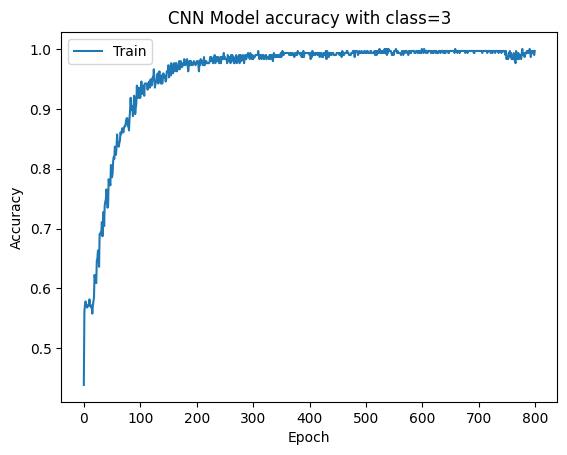

In [38]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

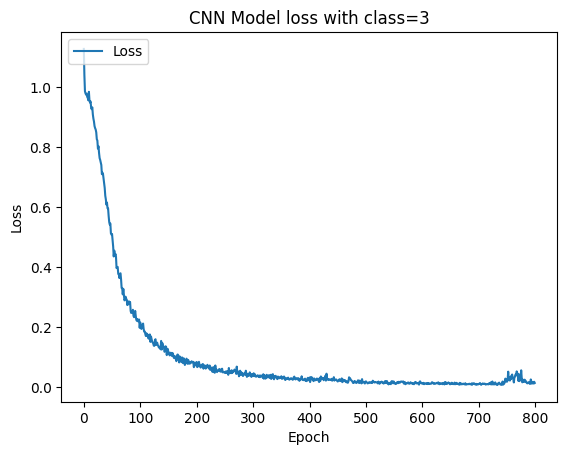

In [39]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()


In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [45]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 20ms/step
0.6756756756756757
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.65      0.89      0.75        36
           2       0.77      0.43      0.56        23

   micro avg       0.68      0.68      0.68        74
   macro avg       0.70      0.62      0.63        74
weighted avg       0.69      0.68      0.66        74
 samples avg       0.68      0.68      0.68        74

auc score:  0.713836045047331


In [46]:
y_test_CNN = CNN_model.predict(feature_test)
# convert the test vector
test_y_CNN = y_test_CNN.copy()
for i in range(len(y_test_CNN)):
    j = np.where(y_test_CNN[i] == np.amax(y_test_CNN[i]))
    test_y_CNN[i] = [0, 0, 0]
    test_y_CNN[i][j] = 1

print(accuracy_score(label_test_y,test_y_CNN))
print(classification_report(label_test_y,test_y_CNN))
print("auc score: ",roc_auc_score(label_test_y,test_y_CNN))

3/3 [==============================] - 0s 19ms/step
0.5698924731182796
              precision    recall  f1-score   support

           0       0.90      0.53      0.67        17
           1       0.56      0.79      0.65        43
           2       0.45      0.30      0.36        33

   micro avg       0.57      0.57      0.57        93
   macro avg       0.64      0.54      0.56        93
weighted avg       0.58      0.57      0.55        93
 samples avg       0.57      0.57      0.57        93

auc score:  0.644996974569658


In [166]:
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

def create_CNN_model():
    CNN = Sequential()
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True))

    CNN.add(Convolution1D(256, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(128, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(64, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Flatten())
    CNN.add(Dense(units = 512 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.3))
    CNN.add(Dense(units = 256 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.3))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    CNN.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return CNN

CNN_model = create_CNN_model()

# 创建ModelCheckpoint回调函数
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

class_weights = {0: 1.0, 1: 0.5, 2: 3.0}
CNN_history = CNN_model.fit(feature_train, label_train_y,
                            epochs=700, batch_size=128,
                            validation_data=(feature_valid, label_valid_y),
                            class_weight=class_weights,
                            callbacks=[checkpoint])  # 将回调函数传递给fit函数

Epoch 1/700
3/3 [==============================] - ETA: 0s - loss: 9.0830 - accuracy: 0.3707
Epoch 1: val_accuracy improved from -inf to 0.31081, saving model to best_model.h5
3/3 [==============================] - 3s 252ms/step - loss: 9.0830 - accuracy: 0.3707 - val_loss: 7.9690 - val_accuracy: 0.3108
Epoch 2/700
2/3 [===================>..........] - ETA: 0s - loss: 8.1236 - accuracy: 0.2656

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.31081
3/3 [==============================] - 0s 57ms/step - loss: 8.0880 - accuracy: 0.3027 - val_loss: 7.8911 - val_accuracy: 0.3108
Epoch 3/700
3/3 [==============================] - ETA: 0s - loss: 7.6254 - accuracy: 0.5034
Epoch 3: val_accuracy did not improve from 0.31081
3/3 [==============================] - 0s 86ms/step - loss: 7.6254 - accuracy: 0.5034 - val_loss: 7.8668 - val_accuracy: 0.3108
Epoch 4/700
3/3 [==============================] - ETA: 0s - loss: 7.5257 - accuracy: 0.4626
Epoch 4: val_accuracy did not improve from 0.31081
3/3 [==============================] - 0s 83ms/step - loss: 7.5257 - accuracy: 0.4626 - val_loss: 7.8083 - val_accuracy: 0.3108
Epoch 5/700
3/3 [==============================] - ETA: 0s - loss: 7.4340 - accuracy: 0.5306
Epoch 5: val_accuracy did not improve from 0.31081
3/3 [==============================] - 0s 83ms/step - loss: 7.4340 - accuracy: 0.5306 - val_loss: 7.7605 - val_accuracy: 0.3108
Epoc

In [167]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

3/3 [==============================] - 0s 4ms/step
0.7702702702702703
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.73      0.89      0.80        36
           2       0.80      0.70      0.74        23

   micro avg       0.77      0.77      0.77        74
   macro avg       0.81      0.73      0.75        74
weighted avg       0.78      0.77      0.77        74
 samples avg       0.77      0.77      0.77        74

auc score:  0.7955618440043882


In [168]:
y_test_CNN = CNN_model.predict(feature_test)
# convert the test vector
test_y_CNN = y_test_CNN.copy()
for i in range(len(y_test_CNN)):
    j = np.where(y_test_CNN[i] == np.amax(y_test_CNN[i]))
    test_y_CNN[i] = [0, 0, 0]
    test_y_CNN[i][j] = 1

print(accuracy_score(label_test_y,test_y_CNN))
print(classification_report(label_test_y,test_y_CNN))
print("auc score: ",roc_auc_score(label_test_y,test_y_CNN))

3/3 [==============================] - 0s 4ms/step
0.7096774193548387
              precision    recall  f1-score   support

           0       1.00      0.53      0.69        17
           1       0.70      0.81      0.75        43
           2       0.65      0.67      0.66        33

   micro avg       0.71      0.71      0.71        93
   macro avg       0.78      0.67      0.70        93
weighted avg       0.74      0.71      0.71        93
 samples avg       0.71      0.71      0.71        93

auc score:  0.751671986624107


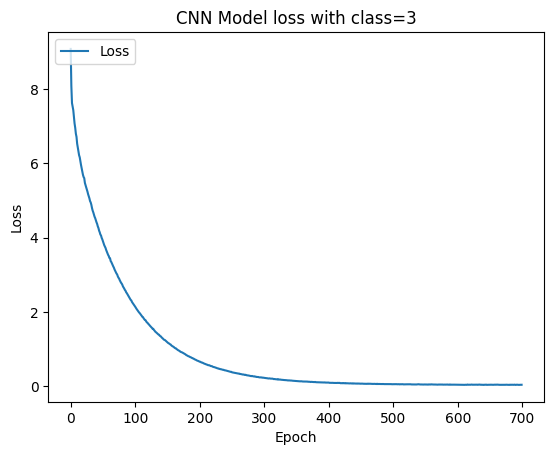

In [169]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

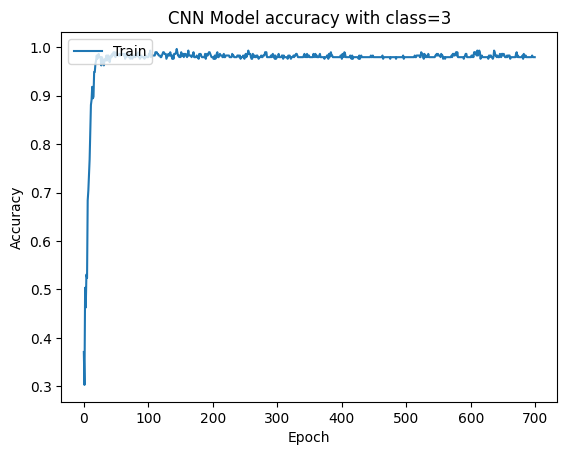

In [170]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

#不好使的

In [46]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(3, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN

RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128, validation_data=(feature_valid, label_valid_y))

Epoch 1/800
3/3 [==============================] - 4s 405ms/step - loss: 1.0818 - accuracy: 0.4150 - val_loss: 1.0438 - val_accuracy: 0.4865
Epoch 2/800
3/3 [==============================] - 0s 29ms/step - loss: 0.9848 - accuracy: 0.5714 - val_loss: 1.0760 - val_accuracy: 0.4865
Epoch 3/800
3/3 [==============================] - 0s 32ms/step - loss: 0.9833 - accuracy: 0.5714 - val_loss: 1.0695 - val_accuracy: 0.4865
Epoch 4/800
3/3 [==============================] - 0s 30ms/step - loss: 0.9751 - accuracy: 0.5714 - val_loss: 1.0536 - val_accuracy: 0.4865
Epoch 5/800
3/3 [==============================] - 0s 29ms/step - loss: 0.9748 - accuracy: 0.5714 - val_loss: 1.0464 - val_accuracy: 0.4865
Epoch 6/800
3/3 [==============================] - 0s 30ms/step - loss: 0.9744 - accuracy: 0.5714 - val_loss: 1.0396 - val_accuracy: 0.4865
Epoch 7/800
3/3 [==============================] - 0s 32ms/step - loss: 0.9762 - accuracy: 0.5714 - val_loss: 1.0414 - val_accuracy: 0.4865
Epoch 8/800
3/3 [==

In [54]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(3, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return RNN

RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=128, validation_data=(feature_valid, label_valid_y))

Epoch 1/800
3/3 [==============================] - 4s 432ms/step - loss: 1.0432 - accuracy: 0.4388 - val_loss: 1.0469 - val_accuracy: 0.4865
Epoch 2/800
3/3 [==============================] - 0s 31ms/step - loss: 0.9820 - accuracy: 0.5714 - val_loss: 1.0850 - val_accuracy: 0.4865
Epoch 3/800
3/3 [==============================] - 0s 30ms/step - loss: 0.9896 - accuracy: 0.5714 - val_loss: 1.0943 - val_accuracy: 0.4865
Epoch 4/800
3/3 [==============================] - 0s 29ms/step - loss: 0.9840 - accuracy: 0.5714 - val_loss: 1.0665 - val_accuracy: 0.4865
Epoch 5/800
3/3 [==============================] - 0s 28ms/step - loss: 0.9853 - accuracy: 0.5714 - val_loss: 1.0526 - val_accuracy: 0.4865
Epoch 6/800
3/3 [==============================] - 0s 29ms/step - loss: 0.9785 - accuracy: 0.5714 - val_loss: 1.0431 - val_accuracy: 0.4865
Epoch 7/800
3/3 [==============================] - 0s 29ms/step - loss: 0.9764 - accuracy: 0.5714 - val_loss: 1.0456 - val_accuracy: 0.4865
Epoch 8/800
3/3 [==

In [47]:
# validation with the RNN
y_valid_RNN = RNN_model.predict(feature_valid)
valid_y_RNN = y_valid_RNN.copy()
for i in range(len(y_valid_RNN)):
    j = np.where(y_valid_RNN[i] == np.amax(y_valid_RNN[i]))
    valid_y_RNN[i] = [0, 0, 0]
    valid_y_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_RNN))
print(classification_report(label_valid_y,valid_y_RNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_RNN))

3/3 [==============================] - 1s 7ms/step
0.6081081081081081
              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.61      0.75      0.67        36
           2       0.50      0.43      0.47        23

   micro avg       0.61      0.61      0.61        74
   macro avg       0.64      0.57      0.59        74
weighted avg       0.62      0.61      0.60        74
 samples avg       0.61      0.61      0.61        74

auc score:  0.6734617974198431


In [48]:
y_test_RNN = RNN_model.predict(feature_test)
# convert the test vector
test_y_RNN = y_test_RNN.copy()
for i in range(len(y_test_RNN)):
    j = np.where(y_test_RNN[i] == np.amax(y_test_RNN[i]))
    test_y_RNN[i] = [0, 0, 0]
    test_y_RNN[i][j] = 1

print(accuracy_score(label_test_y,test_y_RNN))
print(classification_report(label_test_y,test_y_RNN))
print("auc score: ",roc_auc_score(label_test_y,test_y_RNN))

3/3 [==============================] - 0s 7ms/step
0.6451612903225806
              precision    recall  f1-score   support

           0       0.62      0.47      0.53        17
           1       0.67      0.86      0.76        43
           2       0.60      0.45      0.52        33

   micro avg       0.65      0.65      0.65        93
   macro avg       0.63      0.60      0.60        93
weighted avg       0.64      0.65      0.63        93
 samples avg       0.65      0.65      0.65        93

auc score:  0.6988571109612941


In [55]:
from keras.layers import Bidirectional, GRU, LSTM, Attention, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, Conv1D, MaxPooling1D
from keras.models import Model

def create_CNN_RNN_model():
    inputs = Input(shape=(maxlen,))
    embeddings = Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False)(inputs)

    conv1 = Conv1D(128, 3, activation='relu')(embeddings)
    pool1 = MaxPooling1D(3)(conv1)
    conv2 = Conv1D(128, 3, activation='relu')(pool1)
    pool2 = MaxPooling1D(3)(conv2)

    gru1 = Bidirectional(GRU(128, return_sequences=True))(pool2)
    gru2 = Bidirectional(GRU(64, return_sequences=True))(gru1)

    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(pool2)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)

    concat = Concatenate(axis=-1)([gru2, lstm2])

    attention = Attention()([concat, concat])

    pool = GlobalMaxPooling1D()(attention)

    dense1 = Dense(128, activation='relu')(pool)
    dropout1 = Dropout(0.5)(dense1)

    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)

    outputs = Dense(3, activation='softmax')(dropout2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model



In [59]:
CNN_RNN_model = create_CNN_RNN_model()
CNN_RNN_history = CNN_RNN_model.fit(feature_train, label_train_y, epochs=750, batch_size=128,validation_data=(feature_valid, label_valid_y))

Epoch 1/750
3/3 [==============================] - 16s 1s/step - loss: 1.0204 - accuracy: 0.5374 - val_loss: 1.0792 - val_accuracy: 0.4865
Epoch 2/750
3/3 [==============================] - 0s 33ms/step - loss: 1.0279 - accuracy: 0.5306 - val_loss: 1.0389 - val_accuracy: 0.4865
Epoch 3/750
3/3 [==============================] - 0s 32ms/step - loss: 1.0366 - accuracy: 0.5170 - val_loss: 1.0408 - val_accuracy: 0.4865
Epoch 4/750
3/3 [==============================] - 0s 31ms/step - loss: 1.0300 - accuracy: 0.5578 - val_loss: 1.0419 - val_accuracy: 0.4865
Epoch 5/750
3/3 [==============================] - 0s 33ms/step - loss: 1.0017 - accuracy: 0.5714 - val_loss: 1.0471 - val_accuracy: 0.4865
Epoch 6/750
3/3 [==============================] - 0s 33ms/step - loss: 0.9766 - accuracy: 0.5612 - val_loss: 1.0561 - val_accuracy: 0.4865
Epoch 7/750
3/3 [==============================] - 0s 33ms/step - loss: 1.0067 - accuracy: 0.5748 - val_loss: 1.0432 - val_accuracy: 0.4865
Epoch 8/750
3/3 [====

In [62]:
# validation with the RNN
y_valid_CNN_RNN = CNN_RNN_model.predict(feature_valid)
valid_y_CNN_RNN = y_valid_CNN_RNN.copy()
for i in range(len(y_valid_CNN_RNN)):
    j = np.where(y_valid_CNN_RNN[i] == np.amax(y_valid_CNN_RNN[i]))
    valid_y_CNN_RNN[i] = [0, 0, 0]
    valid_y_CNN_RNN[i][j] = 1

# print acc and report
print(accuracy_score(label_valid_y,valid_y_CNN_RNN))
print(classification_report(label_valid_y,valid_y_CNN_RNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN_RNN))

3/3 [==============================] - 0s 7ms/step
0.6081081081081081
              precision    recall  f1-score   support

           0       0.89      0.53      0.67        15
           1       0.57      0.81      0.67        36
           2       0.57      0.35      0.43        23

   micro avg       0.61      0.61      0.61        74
   macro avg       0.68      0.56      0.59        74
weighted avg       0.63      0.61      0.59        74
 samples avg       0.61      0.61      0.61        74

auc score:  0.6621952326764093


In [63]:
y_test_CNN_RNN = CNN_RNN_model.predict(feature_test)
# convert the test vector
test_y_CNN_RNN = y_test_CNN_RNN.copy()
for i in range(len(y_test_CNN_RNN)):
    j = np.where(y_test_CNN_RNN[i] == np.amax(y_test_CNN_RNN[i]))
    test_y_CNN_RNN[i] = [0, 0, 0]
    test_y_CNN_RNN[i][j] = 1

print(accuracy_score(label_test_y,test_y_CNN_RNN))
print(classification_report(label_test_y,test_y_CNN_RNN))
print("auc score: ",roc_auc_score(label_test_y,test_y_CNN_RNN))

3/3 [==============================] - 0s 7ms/step
0.5806451612903226
              precision    recall  f1-score   support

           0       0.67      0.35      0.46        17
           1       0.57      0.81      0.67        43
           2       0.57      0.39      0.46        33

   micro avg       0.58      0.58      0.58        93
   macro avg       0.60      0.52      0.53        93
weighted avg       0.59      0.58      0.56        93
 samples avg       0.58      0.58      0.58        93

auc score:  0.6391156179841472


# 预训练

In [16]:
import torch
from transformers import BertTokenizer, BertModel

# 加载预训练的 BERT 模型和分词器
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name)

# 创建一个字典来存储词及其对应的向量表示
BERT = {}

# 将 train_text_words 拆分成批次
batch_size = 512
num_batches = len(train_text_words) // batch_size + 1

for i in range(num_batches):
    # 获取当前批次的词
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, len(train_text_words))
    batch_words = train_text_words[start_index:end_index]

    # 将词转换为字符串列表
    batch_sentences = [' '.join(batch_words)]

    # 将字符串列表编码为 BERT 的输入格式
    encoded_inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors='pt')

    # 使用 BERT 模型获取词的向量表示
    with torch.no_grad():
        model_outputs = bert_model(**encoded_inputs)
        word_embeddings = model_outputs.last_hidden_state

    # 获取每个词的向量表示
    for sentence in batch_sentences:
        # 将句子编码为 BERT 的输入格式
        encoded_inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
        # 获取句子中的每个词
        words = tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'][0])

        for j, word in enumerate(words):
            # 如果词是子词(以 ## 开头),则跳过
            if word.startswith('##'):
                continue

            # 如果词还没有在字典中,则将其添加到字典中
            if word not in BERT:
                # 获取词的向量表示
                word_vector = word_embeddings[0][j].cpu().numpy()
                # 将词及其对应的向量表示添加到字典中
                BERT[word] = word_vector

# 打印词向量字典的大小
print("词向量字典的大小:", len(BERT))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# 将BERT存储到文件
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/BERT.pkl', 'wb') as f:
    pickle.dump(BERT, f)

In [ ]:
# 从文件中加载BERT
with open('/content/gdrive/MyDrive/Colab Notebooks/NLP_app/BERT.pkl', 'rb') as f:
    loaded_BERT = pickle.load(f)

# 现在可以使用加载后的BERT进行相关操作
print(loaded_BERT['applies'])

In [48]:
BERT['applies']

array([ 5.15429616e-01,  1.27438772e+00,  8.94290507e-01,  2.61702716e-01,
        4.52505797e-01,  4.34847206e-01,  7.73696721e-01,  2.98062805e-02,
        7.60203227e-02, -3.31532001e-01,  2.21079975e-01, -1.15030102e-01,
        1.09592281e-01, -2.62939394e-01,  4.41898890e-02,  1.45336089e-03,
        2.71368295e-01, -4.67662454e-01, -9.24305201e-01, -2.42684379e-01,
        2.80374855e-01,  2.42467627e-01, -7.09719360e-01, -4.72268388e-02,
        1.59784108e-01,  3.77158731e-01,  4.65178996e-01, -8.84478152e-01,
       -2.99527436e-01, -5.44966638e-01,  7.43205547e-01,  4.52126145e-01,
        3.93232852e-02, -2.94771850e-01, -7.91562617e-01, -6.51823699e-01,
       -6.50480315e-02,  3.92983973e-01, -5.51143527e-01,  9.05102730e-01,
       -9.19793487e-01, -4.46531802e-01,  8.16921443e-02, -1.17146127e-01,
        4.46869671e-01, -3.59070063e-01, -7.50101030e-01, -8.96791458e-01,
       -2.45118782e-01, -1.06866136e-01, -7.80152008e-02, -5.15955627e-01,
        3.47108781e-01, -

In [237]:
key_words = ['asset', 'diversification', 'risk', 'allocation', 'investing', 'income', 'passive', 'active', 'fundamental', 'technical', 'equities', 'bonds', 'funds', 'ETFs', 'tolerance', 'portfolio', 'returns']

In [242]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in BERT')

        knowledge_base.update(neighbors)

        out.update(progress(ii, len(key_words)-1))
    return knowledge_base

knowledge_base = create_knowledge_base(10, BERT, key_words)
print(knowledge_base)

diversification not in BERT
equities not in BERT
ETFs not in BERT
{'concentrate', 'appropriate', 'percentage', 'engaging', 'maintenance', 'returns', 'certificates', 'offset', 'requirements', 'investor', 'reaction', 'directional', 'marketing', 'invest', 'expense', 'ETFs', 'assist', 'trusts', 'tolerance', 'interest', 'neutral', 'detailed', 'loans', 'share', 'practical', 'equities', 'transactions', 'bond', 'statutory', 'quantitative', 'savings', 'return', 'portfolio', 'wealth', 'investors', 'investments', 'heading', 'speculative', 'income', 'passive', 'legal', 'technical', 'diversification', 'risks', 'aggressive', 'asset', 'funding', 'accounts', 'yields', 'account', 'accepts', 'contractual', 'premium', 'prediction', 'complex', 'renewal', 'transition', 'fund', 'value', 'shares', 'capital', 'funds', 'investment', 'withdrawing', 'bills', 'dependency', 'exclusive', 'earnings', 'annual', 'invested', 'concentration', 'risk', 'guarantees', 'open', 'researching', 'calculations', 'norm', 'investin

In [243]:
len(knowledge_base)

111

In [250]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise

        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)

#prepare the train,validation and test dataframe
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_valid)
X_test_df = pd.DataFrame(X_test)

X_train_df['sentences_distance'] = X_train_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_valid_df['sentences_distance'] = X_valid_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_test_df['sentences_distance'] = X_test_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [249]:
X_train

149    MainStay VP Epoch U.S. Small Cap Portfolio\n\n...
436    INVESTMENT OBJECTIVE\nThe USAA Managed Allocat...
394    Franklin Payout 2018 Fund\n\nInvestment Goal\n...
440    INVESTMENT OBJECTIVE\nThe USAA Aggressive Grow...
330    Fund Summary\n\nFund/Class:\nFidelity Freedom®...
                             ...                        
152    MainStay VP MacKay International Equity Portfo...
158    MainStay VP MacKay Small Cap Core Portfolio\n\...
374    Franklin LibertyQ U.S. Mid Cap Equity ETF\n\nI...
308    PIMCO Gurtin California Municipal Intermediate...
287    Ivy Small Cap Growth Fund\n\nObjective\n\nTo s...
Name: summary, Length: 294, dtype: object

In [251]:
X_train_df

,summary,sentences_distance
149,MainStay VP Epoch U.S. Small Cap Portfolio\n\n...,19\n\nMainStay VP Epoch U.S. Small Cap Portfol...
436,INVESTMENT OBJECTIVE\nThe USAA Managed Allocat...,1 Year\t3 Years\t5 Years\t10 Years\n$93\t$290\...
394,Franklin Payout 2018 Fund\n\nInvestment Goal\n...,2. 3. A higher portfolio turnover rate may ind...
440,INVESTMENT OBJECTIVE\nThe USAA Aggressive Grow...,1 Year\t3 Years\t5 Years\t10 Years\nFund Share...
330,Fund Summary\n\nFund/Class:\nFidelity Freedom®...,"""Growth"" Investing. ""Growth"" stocks can perfor..."
...,...,...
152,MainStay VP MacKay International Equity Portfo...,35\n\nMainStay VP MacKay International Equity ...
158,MainStay VP MacKay Small Cap Core Portfolio\n\...,47\n\nMainStay VP MacKay Small Cap Core Portfo...
374,Franklin LibertyQ U.S. Mid Cap Equity ETF\n\nI...,A figure of 1.00 would indicate perfect correl...
308,PIMCO Gurtin California Municipal Intermediate...,A higher portfolio turnover rate may indicate ...


In [255]:
X_train_df['sentences_distance'][149]

'19\n\nMainStay VP Epoch U.S. Small Cap Portfolio\n\nPrincipal Risks\nYou can lose money by investing in the Portfolio. 20\n\nMainStay VP Epoch U.S. Small Cap Portfolio\n\nPerformance data for the classes varies based on differences in their fee and expense structures. 21\n\nMainStay VP Epoch U.S. Small Cap Portfolio\n\nCompensation to Broker/Dealers and Other Financial Intermediaries\nThe Portfolio and/or its related companies may pay NYLIAC or other participating insurance companies, broker/dealers, or other financial intermediaries for the sale of Portfolio shares and related services. A higher portfolio turnover rate may indicate higher transaction costs. Also, issuers of convertible securities are often not as strong financially as those issuing securities with higher credit ratings, are more likely to encounter financial difficulties and typically are more vulnerable to changes in the economy, such as a recession or a sustained period of rising interest rates, which could affect 

In [245]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)

X_train_df['sentences_match'] = X_train_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_valid_df['sentences_match'] = X_valid_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_test_df['sentences_match'] = X_test_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)

# produce train_X and test_X
train_X = X_train_df['sentences_match'].values
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

valid_X = X_valid_df['sentences_match'].values
valid_X = [' '.join(tokenizer(txt)) for txt in valid_X]

test_X = X_test_df['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

# produce train_y and valid_y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()

encoded_train_y = encoder.fit_transform(y_train)
label_train_y = to_categorical(encoded_train_y, num_classes=3)

encoded_valid_y = encoder.transform(y_valid)
label_valid_y = to_categorical(encoded_valid_y, num_classes=3)

encoded_test_y = encoder.fit_transform(y_test)
label_test_y = to_categorical(encoded_test_y, num_classes=3)

num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

keras_tokenizer = Tokenizer(num_words=num_words)

keras_tokenizer.fit_on_texts(train_X)

word_index = keras_tokenizer.word_index

sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_valid = keras_tokenizer.texts_to_sequences(valid_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)

# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid = pad_sequences(sequences_valid, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')

# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [248]:
X_train_df

,summary,sentences_distance,sentences_match
149,MainStay VP Epoch U.S. Small Cap Portfolio\n\n...,19\n\nMainStay VP Epoch U.S. Small Cap Portfol...,The security selection process focuses on free...
436,INVESTMENT OBJECTIVE\nThe USAA Managed Allocat...,1 Year\t3 Years\t5 Years\t10 Years\n$93\t$290\...,There are no minimum initial or subsequent pur...
394,Franklin Payout 2018 Fund\n\nInvestment Goal\n...,2. 3. A higher portfolio turnover rate may ind...,Total annual Fund operating expenses differ fr...
440,INVESTMENT OBJECTIVE\nThe USAA Aggressive Grow...,1 Year\t3 Years\t5 Years\t10 Years\nFund Share...,These payments may create a conflict of intere...
330,Fund Summary\n\nFund/Class:\nFidelity Freedom®...,"""Growth"" Investing. ""Growth"" stocks can perfor...",This example helps compare the cost of investi...
...,...,...,...
152,MainStay VP MacKay International Equity Portfo...,35\n\nMainStay VP MacKay International Equity ...,The table does not include any separate accoun...
158,MainStay VP MacKay Small Cap Core Portfolio\n\...,47\n\nMainStay VP MacKay Small Cap Core Portfo...,The table does not include any separate accoun...
374,Franklin LibertyQ U.S. Mid Cap Equity ETF\n\nI...,A figure of 1.00 would indicate perfect correl...,Tracking error may occur because of difference...
308,PIMCO Gurtin California Municipal Intermediate...,A higher portfolio turnover rate may indicate ...,This Fee Waiver Agreement renews annually unle...


In [247]:
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

def create_CNN_model():
    CNN = Sequential()
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=True))

    CNN.add(Convolution1D(256, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(128, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Convolution1D(64, 3, activation = 'relu'))
    CNN.add(BatchNormalization())
    CNN.add(MaxPooling1D(pool_size = 3))

    CNN.add(Flatten())
    CNN.add(Dense(units = 512 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.3))
    CNN.add(Dense(units = 256 , activation = 'relu', kernel_regularizer=l2(0.01)))
    CNN.add(Dropout(0.3))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    CNN.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return CNN

CNN_model = create_CNN_model()

# 创建ModelCheckpoint回调函数
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

class_weights = {0: 1.0, 1: 0.5, 2: 3.0}
CNN_history = CNN_model.fit(feature_train, label_train_y,
                            epochs=700, batch_size=128,
                            validation_data=(feature_valid, label_valid_y),
                            class_weight=class_weights,
                            callbacks=[checkpoint])  # 将回调函数传递给fit函数

Epoch 1/700
1/3 [=========>....................] - ETA: 47s - loss: 8.1034 - accuracy: 0.2969
Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to best_model.h5
3/3 [==============================] - 24s 210ms/step - loss: 8.0705 - accuracy: 0.2755 - val_loss: 7.9020 - val_accuracy: 0.4865
Epoch 2/700
1/3 [=========>....................] - ETA: 0s - loss: 8.1411 - accuracy: 0.2656
Epoch 2: val_accuracy did not improve from 0.48649
3/3 [==============================] - 0s 27ms/step - loss: 8.0777 - accuracy: 0.2585 - val_loss: 7.8531 - val_accuracy: 0.3108
Epoch 3/700
1/3 [=========>....................] - ETA: 0s - loss: 7.9477 - accuracy: 0.3594
Epoch 3: val_accuracy did not improve from 0.48649
3/3 [==============================] - 0s 25ms/step - loss: 7.9210 - accuracy: 0.3231 - val_loss: 7.8073 - val_accuracy: 0.3108
Epoch 4/700
1/3 [=========>....................] - ETA: 0s - loss: 7.8780 - accuracy: 0.2812
Epoch 4: val_accuracy did not improve from 0.48649
3/3 [

In [ ]:
y_valid_CNN = CNN_model.predict(feature_valid)

# convert the validation vector
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1

print(accuracy_score(label_valid_y,valid_y_CNN))
print(classification_report(label_valid_y,valid_y_CNN))
print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

In [ ]:
y_test_CNN = CNN_model.predict(feature_test)
# convert the test vector
test_y_CNN = y_test_CNN.copy()
for i in range(len(y_test_CNN)):
    j = np.where(y_test_CNN[i] == np.amax(y_test_CNN[i]))
    test_y_CNN[i] = [0, 0, 0]
    test_y_CNN[i][j] = 1

print(accuracy_score(label_test_y,test_y_CNN))
print(classification_report(label_test_y,test_y_CNN))
print("auc score: ",roc_auc_score(label_test_y,test_y_CNN))

#预训练（直接预测）

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')  # 使用CPU

# 加载预训练的DistilBERT模型和tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y_train)))
model.to(device)

# 准备数据集
def prepare_data(texts, labels, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded_dict = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    labels = torch.tensor(labels)
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks, labels

encoder = LabelEncoder()

encoded_train_y = encoder.fit_transform(y_train)
label_train_y = to_categorical(encoded_train_y, num_classes=3)

encoded_valid_y = encoder.transform(y_valid)
label_valid_y = to_categorical(encoded_valid_y, num_classes=3)

encoded_test_y = encoder.fit_transform(y_test)
label_test_y = to_categorical(encoded_test_y, num_classes=3)


train_input_ids, train_attention_masks, train_labels = prepare_data(X_train, encoded_train_y, tokenizer)
val_input_ids, val_attention_masks, val_labels = prepare_data(X_valid, encoded_valid_y, tokenizer)
test_input_ids, test_attention_masks, test_labels = prepare_data(X_test, encoded_test_y, tokenizer)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# 创建DataLoader
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)

test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

In [19]:
from tqdm import tqdm
from transformers import Adafactor
# 训练模型
optimizer = Adafactor(model.parameters(), lr=0.01, eps=(1e-30, 1e-3), clip_threshold=1.0, beta1=None, weight_decay=0.0, relative_step=False, scale_parameter=False, warmup_init=False)
epochs = 20
batch_size = 8
accumulation_steps = 4  # 每4个步骤更新一次模型参数

for _ in range(epochs):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {_+1} Training")
    for i, batch in enumerate(progress_bar):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(train_loss/(i+1))})

    model.eval()
    val_preds, val_labels = [], []
    for batch in tqdm(validation_dataloader, desc=f"Epoch {_+1} Validation"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(b_labels.cpu().tolist())

    print(f"Epoch {_+1}, Validation Accuracy: {accuracy_score(val_labels, val_preds)}, Validation F1 (micro): {f1_score(val_labels, val_preds, average='micro')}")

# 在测试集上预测
model.eval()
test_preds, test_labels = [], []
for batch in tqdm(test_dataloader, desc="Testing"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().tolist())
        test_labels.extend(b_labels.cpu().tolist())

print(f"Test Accuracy: {accuracy_score(test_labels, test_preds)}, Test F1 (micro): {f1_score(test_labels, test_preds, average='micro')}")

Epoch 1 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Epoch 1, Validation Accuracy: 0.5, Validation F1 (micro): 0.5


Epoch 2 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Epoch 2, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 3 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


Epoch 3, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 4 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 4, Validation Accuracy: 0.3108108108108108, Validation F1 (micro): 0.3108108108108108


Epoch 5 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Epoch 5, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 6 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Epoch 6, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 7 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 7, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 8 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


Epoch 8, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 9 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch 9, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 10 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epoch 10, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 11 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Epoch 11, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 12 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 12, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 13 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 13, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 14 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epoch 14, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 15 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 15, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 16 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epoch 16, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 17 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epoch 17, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 18 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Epoch 18, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 19 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epoch 19, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Epoch 20 Validation: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epoch 20, Validation Accuracy: 0.4864864864864865, Validation F1 (micro): 0.4864864864864865


Testing: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

Test Accuracy: 0.46236559139784944, Test F1 (micro): 0.46236559139784944
